In [ ]:
import os
import shutil
import tarfile
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import pandas as pd
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import seaborn as sns 
from wordcloud import WordCloud, STOPWORDS # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

/Users/prabhnoorsingh/Documents/sentiment_analysis_bert/.conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Setting gpu for memory
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    #Restrict Tensorflow to allocate 6gb of memory on the first GPU
   try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
       [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6144)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
   except RuntimeError as e:
       #virtual devices must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


2025-05-04 22:56:27.456185: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-05-04 22:56:27.456235: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-05-04 22:56:27.456263: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-05-04 22:56:27.456922: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-04 22:56:27.457299: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
print(tf.__version__)


2.13.0


In [4]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# Get the current working directory
current_folder = os.getcwd()

dataset = tf.keras.utils.get_file(
    fname ="aclImdb.tar.gz", 
    origin ="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    cache_dir=  current_folder,
    extract = True)

In [6]:
dataset_path = os.path.dirname(dataset)
# Check the dataset
os.listdir(dataset_path)

['aclImdb', 'aclImdb.tar.gz']

In [7]:
# Dataset directory
dataset_dir = os.path.join(dataset_path, 'aclImdb')

# Check the Dataset directory
os.listdir(dataset_dir)

['imdbEr.txt', 'test', 'imdb.vocab', 'README', 'train']

In [8]:
train_dir = os.path.join(dataset_dir,'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'neg',
 'urls_pos.txt',
 'unsup',
 'urls_neg.txt',
 'pos',
 'unsupBow.feat',
 'labeledBow.feat']

In [9]:
for file in os.listdir(train_dir):
    file_path = os.path.join(train_dir, file)
    # Check if it's a file (not a directory)
    if os.path.isfile(file_path): 
        with open(file_path, 'r', encoding='utf-8') as f:
            first_value = f.readline().strip()
            print(f"{file}: {first_value}")
    else:
        print(f"{file}: {file_path}")

urls_unsup.txt: http://www.imdb.com/title/tt0018515/usercomments
neg: /Users/prabhnoorsingh/Documents/sentiment_analysis_bert/notebooks/datasets/aclImdb/train/neg
urls_pos.txt: http://www.imdb.com/title/tt0453418/usercomments
unsup: /Users/prabhnoorsingh/Documents/sentiment_analysis_bert/notebooks/datasets/aclImdb/train/unsup
urls_neg.txt: http://www.imdb.com/title/tt0064354/usercomments
pos: /Users/prabhnoorsingh/Documents/sentiment_analysis_bert/notebooks/datasets/aclImdb/train/pos
unsupBow.feat: 0 0:8 1:6 3:5 4:2 5:1 7:1 8:5 9:2 10:1 11:2 13:3 16:1 17:1 18:1 19:1 22:3 24:1 26:3 28:1 30:1 31:1 35:2 36:1 39:2 40:1 41:2 46:2 47:1 48:1 52:1 63:1 67:1 68:1 74:1 81:1 83:1 87:1 104:1 105:1 112:1 117:1 131:1 151:1 155:1 170:1 198:1 225:1 226:1 288:2 291:1 320:1 331:1 342:1 364:1 374:1 384:2 385:1 407:1 437:1 441:1 465:1 468:1 470:1 519:1 595:1 615:1 650:1 692:1 851:1 937:1 940:1 1100:1 1264:1 1297:1 1317:1 1514:1 1728:1 1793:1 1948:1 2088:1 2257:1 2358:1 2584:2 2645:1 2735:1 3050:1 4297:1 5

In [10]:
def load_dataset(directory):
    data = {"sentence": [], "sentiment": []}
    for file_name in os.listdir(directory):
        print(file_name)
        if file_name == 'pos':
            positive_dir = os.path.join(directory, file_name)
            for text_file in os.listdir(positive_dir):
                text = os.path.join(positive_dir, text_file)
                with open(text, "r", encoding="utf-8") as f:
                    data["sentence"].append(f.read())
                    data["sentiment"].append(1)
        elif file_name == 'neg':
            negative_dir = os.path.join(directory, file_name)
            for text_file in os.listdir(negative_dir):
                text = os.path.join(negative_dir, text_file)
                with open(text, "r", encoding="utf-8") as f:
                    data["sentence"].append(f.read())
                    data["sentiment"].append(0)
            
    return pd.DataFrame.from_dict(data)

In [11]:
# Load the dataset from the train_dir
train_df = load_dataset(train_dir)
print(train_df.head())

urls_unsup.txt
neg
urls_pos.txt
unsup
urls_neg.txt
pos
unsupBow.feat
labeledBow.feat
                                            sentence  sentiment
0  Working with one of the best Shakespeare sourc...          0
1  Well...tremors I, the original started off in ...          0
2  Ouch! This one was a bit painful to sit throug...          0
3  I've seen some crappy movies in my life, but t...          0
4  "Carriers" follows the exploits of two guys an...          0


In [12]:
test_dir = os.path.join(dataset_dir,'test')

# Load the dataset from the train_dir
test_df = load_dataset(test_dir)
print(test_df.head())

neg
urls_pos.txt
urls_neg.txt
pos
labeledBow.feat
                                            sentence  sentiment
0  Alan Rickman & Emma Thompson give good perform...          0
1  I have seen this movie and I did not care for ...          0
2  In Los Angeles, the alcoholic and lazy Hank Ch...          0
3  This film is bundled along with "Gli fumavano ...          0
4  I only comment on really very good films and o...          0


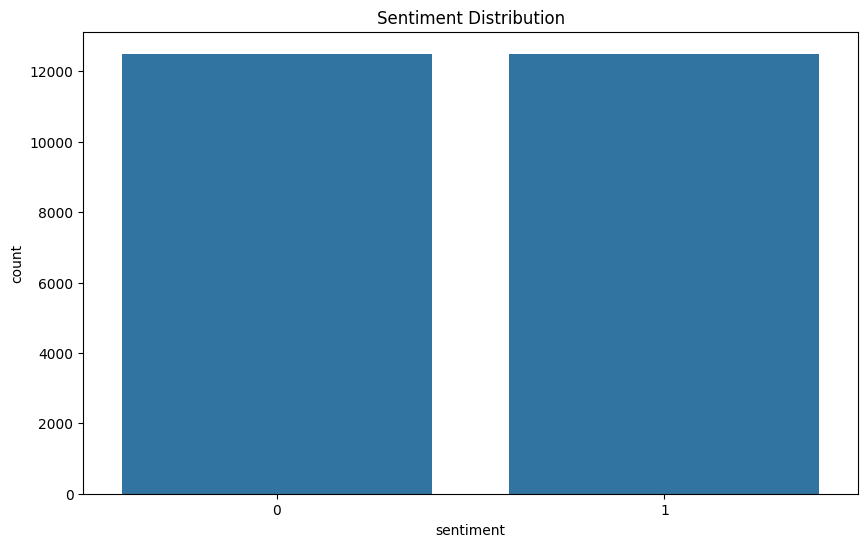

In [13]:
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=train_df)
plt.title('Sentiment Distribution')
plt.show()

In [14]:
#Negative comments value count
negative_comments=train_df[train_df['sentiment']==0].shape[0]

In [15]:
#Positive comments value count
positive_comments=train_df[train_df['sentiment']==1].shape[0]

In [16]:
def remove_html_tags(text):
    return BeautifulSoup(text, "html.parser").get_text()

In [17]:
type(train_df)

pandas.core.frame.DataFrame

In [18]:
train_df['cleaned_sentence'] = train_df['sentence'].apply(remove_html_tags)
test_df['cleaned_sentence'] = test_df['sentence'].apply(remove_html_tags)

In [19]:
type(train_df)

pandas.core.frame.DataFrame

In [20]:
train_df.head()

,sentence,sentiment,cleaned_sentence
0,Working with one of the best Shakespeare sourc...,0,Working with one of the best Shakespeare sourc...
1,"Well...tremors I, the original started off in ...",0,"Well...tremors I, the original started off in ..."
2,Ouch! This one was a bit painful to sit throug...,0,Ouch! This one was a bit painful to sit throug...
3,"I've seen some crappy movies in my life, but t...",0,"I've seen some crappy movies in my life, but t..."
4,"""Carriers"" follows the exploits of two guys an...",0,"""Carriers"" follows the exploits of two guys an..."


In [21]:
train_df.drop(columns=['sentence'], inplace=True)
test_df.drop(columns=['sentence'], inplace=True)

In [22]:
def generate_wordcloud(text,Title):
    wordcloud=WordCloud(
        width=700,
        height=400,
        background_color='black',
        colormap='viridis'
    ).generate(text)
    plt.figure(figsize=(13,13))
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.title(Title)
    plt.show()

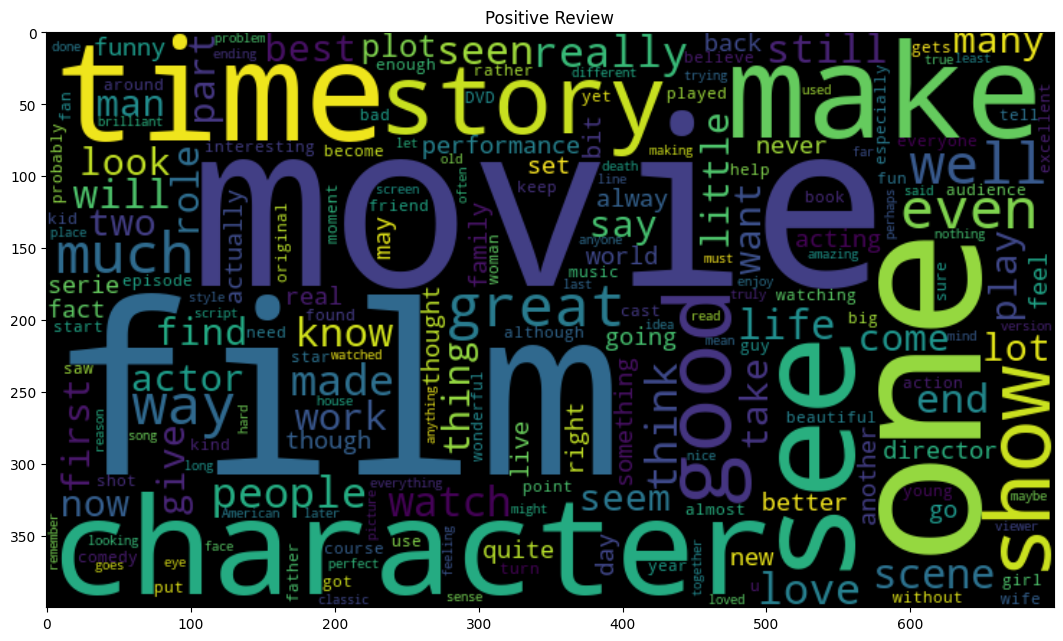

In [23]:
positive= train_df[train_df['sentiment']==1]['cleaned_sentence']
positive_txt=" ".join(positive)
generate_wordcloud(positive_txt,'Positive Review')

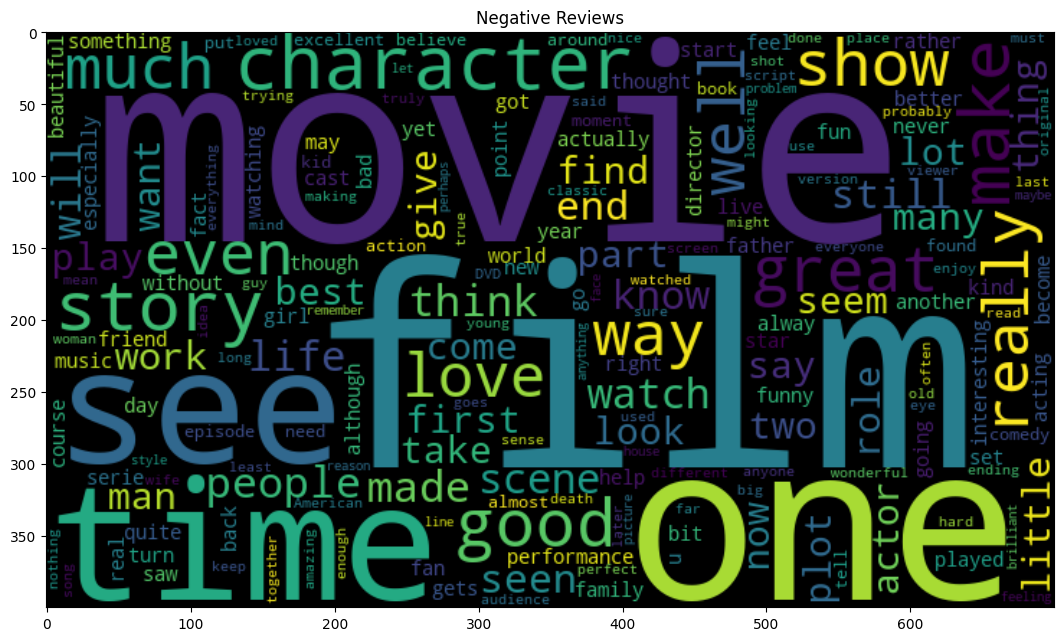

In [24]:
negative=train_df[train_df['sentiment']==1]['cleaned_sentence']
negative_txt=" ".join(negative)
generate_wordcloud(negative_txt,"Negative Reviews")

In [25]:
# Training data
#Reviews = "[CLS] " +train_df['Cleaned_sentence'] + "[SEP]"
Reviews = train_df['cleaned_sentence']
Target = train_df['sentiment']

# Test data
#test_reviews =  "[CLS] " +test_df['Cleaned_sentence'] + "[SEP]"
test_reviews = test_df['cleaned_sentence']
test_targets = test_df['sentiment']

In [26]:
x_val, x_test, y_val, y_test = train_test_split(test_reviews,
                                                    test_targets,
                                                    test_size=0.5, 
                                                    stratify = test_targets)

In [35]:
tokenizer =AutoTokenizer.from_pretrained('distilbert-base-uncased',do_lower_case=True)

In [36]:
max_len=128
X_train_encoded=tokenizer.batch_encode_plus(
    Reviews.tolist(),
    padding=True,
    truncation=True,
    max_length=max_len,
    return_tensors='tf'
)

X_val_encoded=tokenizer.batch_encode_plus(
    x_val.tolist(),
    padding=True,
    truncation=True,
    max_length=max_len,
    return_tensors='tf'
)

X_test_encoded=tokenizer.batch_encode_plus(
    x_test.tolist(),
    padding=True,
    truncation=True,
    max_length=max_len,
    return_tensors='tf'
)

In [37]:
model=TFAutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=2)  

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [38]:
# Compile the model with an appropriate optimizer, loss function, and metrics

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [39]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Available GPUs:", physical_devices)


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [42]:
history = model.fit(
  {'input_ids': X_train_encoded['input_ids'], 'attention_mask': X_train_encoded['attention_mask']},
  Target,
  validation_data=(
    {'input_ids': X_val_encoded['input_ids'], 'attention_mask': X_val_encoded['attention_mask']}, y_val),
  batch_size=32,
  epochs=3
)


Epoch 1/3


2025-05-04 23:33:39.732864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - ETA: 0s - loss: 0.3522 - accuracy: 0.8399

2025-05-05 00:20:30.627971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 3277s 4s/step - loss: 0.3522 - accuracy: 0.8399 - val_loss: 0.2942 - val_accuracy: 0.8710
Epoch 2/3
782/782 [==============================] - 2899s 4s/step - loss: 0.2322 - accuracy: 0.9051 - val_loss: 0.3059 - val_accuracy: 0.8794
Epoch 3/3
782/782 [==============================] - 3312s 4s/step - loss: 0.1455 - accuracy: 0.9455 - val_loss: 0.3253 - val_accuracy: 0.8791


In [ ]:
test_loss, test_accuracy = model.evaluate(
    [X_test_encoded['input_ids'], X_test_encoded['attention_mask']],
    y_test
)

2025-05-05 02:16:06.371957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


391/391 [==============================] - 182s 457ms/step - loss: 0.3212 - accuracy: 0.8796


In [ ]:
path='/Users/prabhnoorsingh/Documents/sentiment_analysis_bert/models'
tokenizer.save_pretrained(path + '/Tokenizer')
model.save_pretrained(path + '/Model')

('/Users/prabhnoorsingh/Documents/sentiment_analysis_bert/models/Tokenizer/tokenizer_config.json',
 '/Users/prabhnoorsingh/Documents/sentiment_analysis_bert/models/Tokenizer/special_tokens_map.json',
 '/Users/prabhnoorsingh/Documents/sentiment_analysis_bert/models/Tokenizer/vocab.txt',
 '/Users/prabhnoorsingh/Documents/sentiment_analysis_bert/models/Tokenizer/added_tokens.json',
 '/Users/prabhnoorsingh/Documents/sentiment_analysis_bert/models/Tokenizer/tokenizer.json')

In [48]:
#loading the saved models
path='/Users/prabhnoorsingh/Documents/sentiment_analysis_bert/models'
distilbert_tok= AutoTokenizer.from_pretrained(path+ '/Tokenizer')
distilbert_mod= TFAutoModelForSequenceClassification.from_pretrained(path + '/Model')


Some layers from the model checkpoint at /Users/prabhnoorsingh/Documents/sentiment_analysis_bert/models/Model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_57']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /Users/prabhnoorsingh/Documents/sentiment_analysis_bert/models/Model and are newly initialized: ['dropout_77']
You should probably TRAIN this model on a down-stream task to be able to use it f

3.2.1
